# Foreign Exchange Forecasting using LSTMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Hyperparameter

In [184]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

SEQ_LEN = 21 # 6, 11, 21
SPLIT = 0.90 # 0.80, 0.90
LSTM_Layer = 3 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

## Data Overview
From Google Finance

In [185]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[1]}'
df = pd.read_csv(url)

# Convert from 100 JPY/IDR to 1 JPY/IDR
# df.replace(12480.17, 124.801, inplace=True) # Only for JPY/IDR

# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


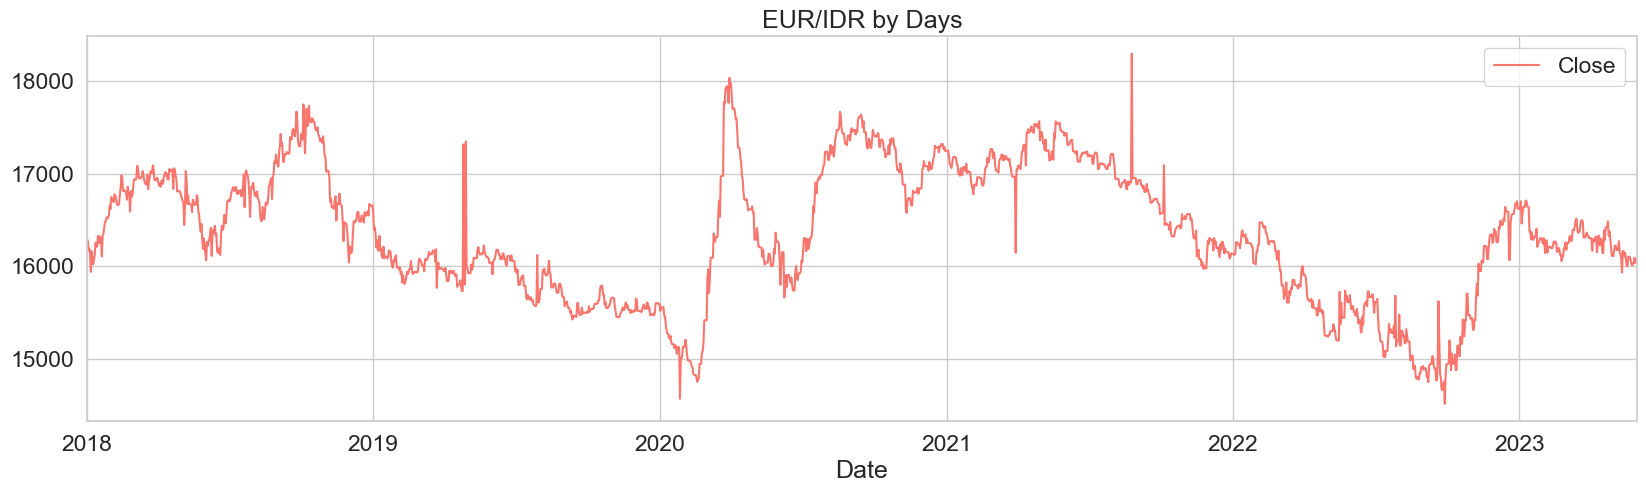

In [186]:
dfplot = df.copy()
dfplot = dfplot.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
dfplot = dfplot.set_index('Date')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dfplot.plot(style='', figsize=(20,5), color=color_pal[0], title=f'{SHEET_NAME[1]} by Days')

## Data preprocessing

### Normalize

In [187]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

### Making sequences

In [188]:
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

In [189]:
print("----------- Train Data Shape -----------")
print(X_train.shape)
print(y_train.shape)
print("----------- Test Data Shape -----------")
print(X_test.shape)
print(y_test.shape)

----------- Train Data Shape -----------
(1760, 20, 1)
(1760, 1)
----------- Test Data Shape -----------
(196, 20, 1)
(196, 1)


## Modeling

### Building LSTM model

In [190]:
model = Sequential()

for i, units in enumerate([128, 64, 32][:LSTM_Layer]):
    model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(units=1))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 20, 128)           66560     
                                                                 
 lstm_30 (LSTM)              (None, 20, 64)            49408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


### Training

In [191]:
BATCH_SIZE = 32
EPOCH = 50
VAL_SPLIT = 0.1

model.compile(
    loss='mse',
    metrics=['mae', RootMeanSquaredError()],
    optimizer='adam',
)
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_split=VAL_SPLIT)

Epoch 1/50
50/50 [==============================] - 7s 74ms/step - loss: 0.0236 - mae: 0.1030 - root_mean_squared_error: 0.1535 - val_loss: 0.0044 - val_mae: 0.0533 - val_root_mean_squared_error: 0.0661
Epoch 2/50
50/50 [==============================] - 3s 59ms/step - loss: 0.0041 - mae: 0.0461 - root_mean_squared_error: 0.0640 - val_loss: 0.0035 - val_mae: 0.0460 - val_root_mean_squared_error: 0.0592
Epoch 3/50
50/50 [==============================] - 3s 58ms/step - loss: 0.0036 - mae: 0.0418 - root_mean_squared_error: 0.0597 - val_loss: 0.0033 - val_mae: 0.0452 - val_root_mean_squared_error: 0.0578
Epoch 4/50
50/50 [==============================] - 3s 57ms/step - loss: 0.0031 - mae: 0.0394 - root_mean_squared_error: 0.0561 - val_loss: 0.0031 - val_mae: 0.0434 - val_root_mean_squared_error: 0.0557
Epoch 5/50
50/50 [==============================] - 3s 57ms/step - loss: 0.0028 - mae: 0.0374 - root_mean_squared_error: 0.0525 - val_loss: 0.0034 - val_mae: 0.0470 - val_root_mean_squared

### Model Evaluation

In [192]:
model.evaluate(X_test, y_test)

1/7 [===>..........................] - ETA: 0s - loss: 5.2705e-04 - mae: 0.0179 - root_mean_squared_error: 0.0230

7/7 [==============================] - 0s 23ms/step - loss: 6.1206e-04 - mae: 0.0174 - root_mean_squared_error: 0.0247


[0.000612061470746994, 0.017436161637306213, 0.02473987638950348]

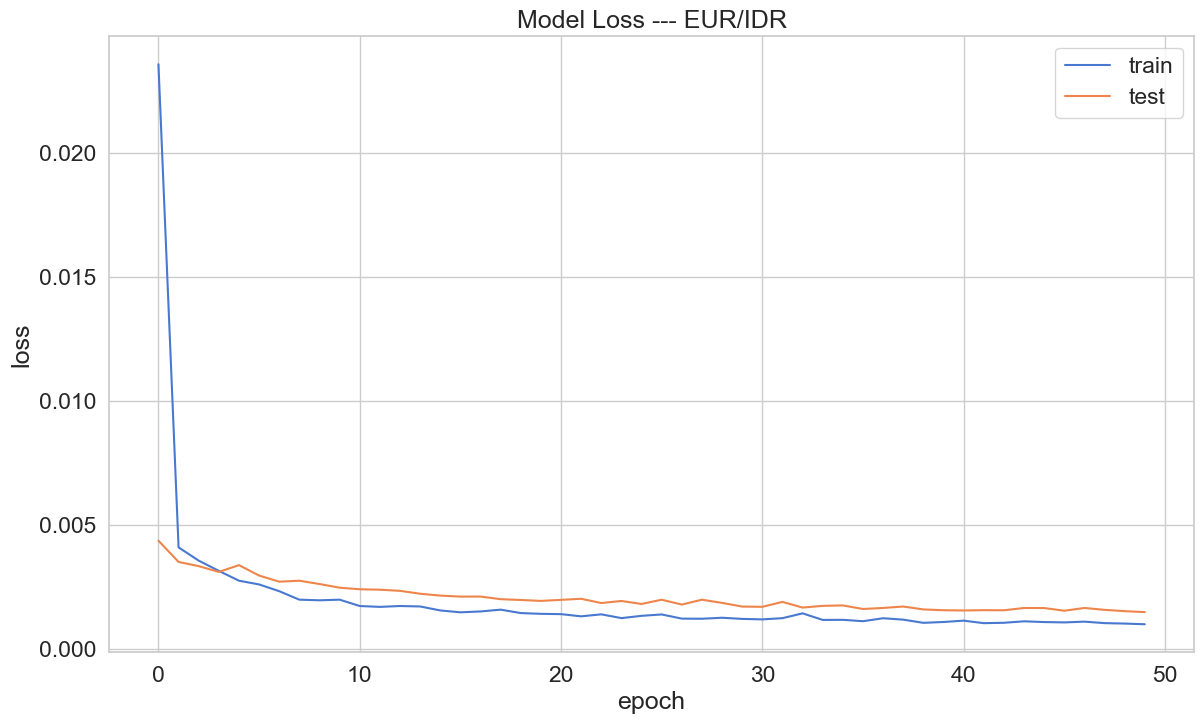

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss --- {SHEET_NAME[1]}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig(f'D:/Collage/Courses/Skripsi/Gambar/Hasil Skenario/{SHEET_NAME[1][:3]} Model Loss_LSTM_{LSTM_Layer}_Split_{SPLIT}_Window_{WINDOW_SIZE}.png')
plt.show()

## Prediction

In [194]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

7/7 [==============================] - 1s 15ms/step


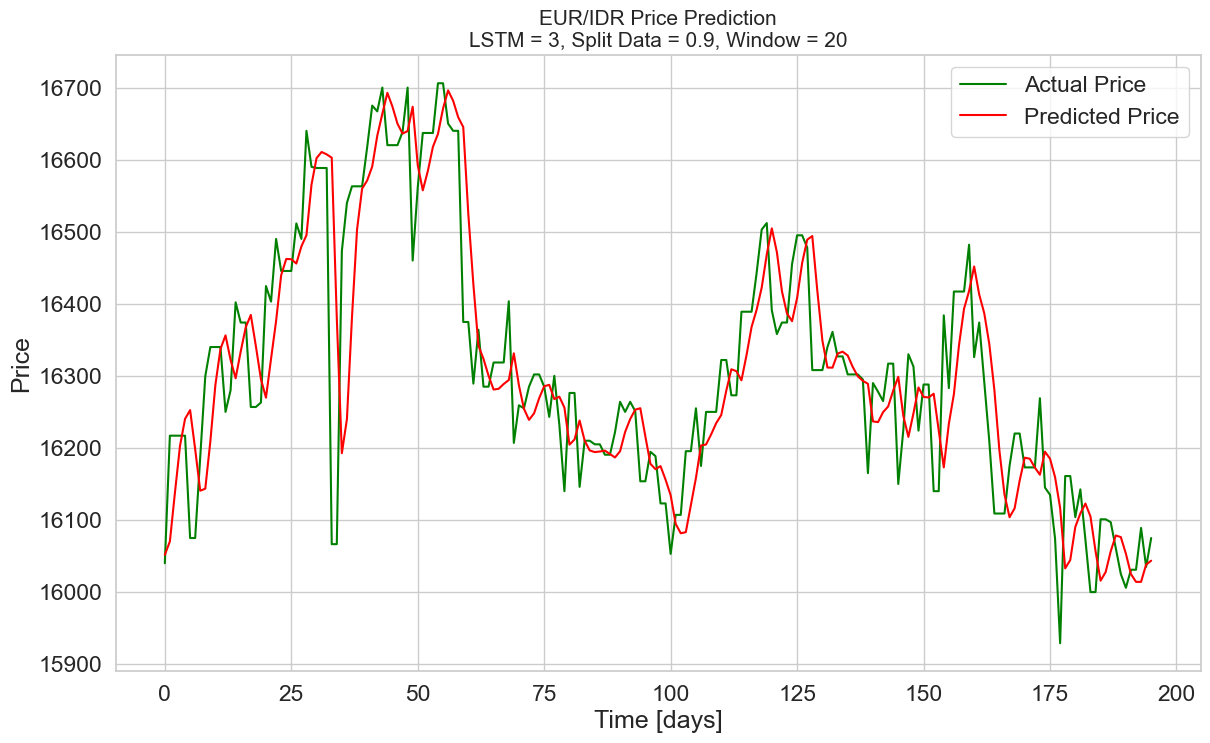

In [195]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title(f'{SHEET_NAME[1]} Price Prediction\nLSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}', fontsize=15)
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.savefig(f'D:/Collage/Courses/Skripsi/Gambar/Hasil Skenario/{SHEET_NAME[1][:3]} Price Prediction_LSTM_{LSTM_Layer}_Split_{SPLIT}_Window_{WINDOW_SIZE}.png')
plt.show()

In [196]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Mean Squared Error for prediction :", mse)
    print("Root Mean Squared Error for prediction :", rmse)
    return mae, mse, rmse

print(f"LSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}")
print("\n----------------- Normalized Error -----------------")
mae, mse, rmse = matrices(y_test, y_hat)
print("\n----------------- Actual Error -----------------")
mae_inverse, mse_inverse, rmse_inverse = matrices(y_test_inverse, y_hat_inverse)

LSTM = 3, Split Data = 0.9, Window = 20

----------------- Normalized Error -----------------
Mean Absolute Error for prediction : 0.01743615988528663
Mean Squared Error for prediction : 0.0006120614066075534
Root Mean Squared Error for prediction : 0.024739874830070452

----------------- Actual Error -----------------
Mean Absolute Error for prediction : 65.97849709024247
Mean Squared Error for prediction : 8763.910288629155
Root Mean Squared Error for prediction : 93.61575876223594


In [197]:
error_result = pd.DataFrame([[SHEET_NAME[1], LSTM_Layer, WINDOW_SIZE, SPLIT, np.nan, mae_inverse, mse_inverse, rmse_inverse]],
                            columns=['Type', 'LSTM Layer', 'Window', 'Split', 'CV (Fold)', 'MAE', 'MSE', 'RMSE'])
hasil = pd.read_excel('Hasil.xlsx')
final = pd.concat([hasil, error_result], ignore_index=True)
final.to_excel('Hasil.xlsx', index=False)